### Import packages

https://www.kaggle.com/code/dlarionov/mnist-spiking-neural-network/notebook

In [4]:
!pip install brian2
!pip install ipympl
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from brian2 import *
import brian2 as b2
from brian2.monitors.spikemonitor import SpikeMonitor
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score

In [2]:
from google.colab import drive 
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import math
from random import shuffle
from collections import Counter
import os
import h5py
# import ipdb # ipdb.set_trace() ### breakpoint
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget
#%matplotlib inline
b2.core.preferences.prefs.codegen.target = "numpy"

b2.defaultclock.dt = 0.1 * b2.ms

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Parameters

In [36]:
n_train = 10 # max 5420 # full 7291
n_test = 10 # max 1470 # full 2007

ni = 16*16
n_classes = 3
nn = 10
max_rate = 63

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV
v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV
taupre = 20*ms
taupost = taupre
gmax = 0.153 # .05 
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax 

train_period = 350 * b2.ms  
time_relax = 150 * b2.ms    

file_path_weights = 'drive/My Drive/Colab Notebooks/investigate_myelin_rule/usps/synapses_e_weights.npy'

### Data loading

In [37]:
current_dir = os.getcwd()
with h5py.File('drive/My Drive/Colab Notebooks/investigate_myelin_rule/usps/usps.h5', 'r') as hf:
        train = hf.get('train')
        train_X = train.get('data')[:]
        train_Y = train.get('target')[:]
        test = hf.get('test')
        test_X = test.get('data')[:]
        test_Y = test.get('target')[:]

In [38]:
train_X = train_X[(train_Y == 1) | (train_Y == 0) | (train_Y == 8)]
train_Y = train_Y[(train_Y == 1) | (train_Y == 0) | (train_Y == 8)]
test_X = test_X[(test_Y == 1) | (test_Y == 0) | (test_Y == 8)]
test_Y = test_Y[(test_Y == 1) | (test_Y == 0) | (test_Y == 8)]

In [39]:
train_X.shape, test_X.shape

((2741, 256), (789, 256))

In [40]:
train_X = train_X*max_rate
test_X = test_X*max_rate

### Model SNN

In [41]:
# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

class Model():
    
    def __init__(self, debug=False):
        app = {}
                
        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(ni, rates=np.zeros(ni)*Hz, name='PG')
        
        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(nn, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV
        
        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')
        
        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(nn, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')
        
        # poisson generators one-to-all excitatory neurons with plastic connections 
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].lr = 1 # enable stdp        
        
        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M') 
        
        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition
        
        self.net = Network(app.values())
        self.net.run(0*second)
        
    def __getitem__(self, key):
        return self.net[key]
    
    def train(self, X, epoch=1):        
        self.net['S1'].lr = 1 # stdp on
        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx]*Hz
                self.net.run(train_period)
                # passive mode
                self.net['PG'].rates = np.zeros(ni)*Hz
                self.net.run(time_relax)
        
    def evaluate(self, X):       
        self.net['S1'].lr = 0  # stdp off
        features = []
        for idx in range(len(X)):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)
            # active mode
            self.net['PG'].rates = X[idx]*Hz
            self.net.run(train_period)
            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))
            # passive mode
            self.net['PG'].rates = np.zeros(ni)*Hz
            self.net.run(time_relax)
            self.net.remove(self.net['RM'])

    def evaluate_one(self, x):       
        self.net['S1'].lr = 0  # stdp off
        # rate monitor to count spikes
        mon = SpikeMonitor(self.net['EG'], name='RM')
        self.net.add(mon)
        # active mode
        self.net['PG'].rates = x*Hz
        self.net.run(train_period)
        # spikes per neuron foreach image
        features = np.array(mon.count, dtype=int8)
        # passive mode
        self.net['PG'].rates = np.zeros(ni)*Hz
        self.net.run(time_relax)
        self.net.remove(self.net['RM'])
            
        return features

### Functions

In [42]:
def CreateClasses(snn, train_rates, labels):
    spike_num = np.zeros([n_classes, nn])
    classes_dic = {}
    n_samples = len(train_rates)
    for i in range(n_samples):
        spike_num[labels[i], :] += snn.evaluate_one(train_rates[i])
        if i % 10 == 0: print(f'Sample done: {i} / {n_samples}')
    for j in range(nn): 
        if np.sum(spike_num[:, j]) > 0.0: 
            classes_dic[j] = str(np.argmax(spike_num[:, j]))
        else: classes_dic[j] = "None"
    print(classes_dic)
    print(spike_num)
    return classes_dic

def predict(snn, test_rates, classes):
    pred = []
    n_samples = len(test_rates)
    for ind, rates_sample in enumerate(test_rates):
        spike_num = snn.evaluate_one(rates_sample) 
        if np.sum(spike_num) > 0.0: 
            spiked_neurons, = np.where(spike_num > 0.0)
            spiked_neurons_preds = []
            for spiked_neuron in spiked_neurons:
                for _ in range(spike_num[spiked_neuron]):
                    spiked_neurons_preds.append(classes[spiked_neuron])
            counted = Counter(spiked_neurons_preds)
            pred += [max(counted, key=counted.get)]
        else: pred += ["None"] 
        if ind % 10 == 0: print(f'Sample done: {ind} / {n_samples}')
    return pred

def show_confusion_matrix(pred, labels):
    data = {'y_Actual': labels, 'y_Predicted': pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (10, 8))
    sn.heatmap(confusion_matrix, annot=True)

def analyse(pred, labels):
    precision = accuracy_score(labels, pred)
    recall = recall_score(labels, pred, average='micro')
    F1_score = f1_score(labels, pred, average='micro')
    return precision, recall, F1_score 

### Training

In [43]:
seed(0)

model = Model()
model.train(train_X[:n_train], epoch=1)
model.net.store('train', 'train.b2')
#model.net.restore('train', './train.b2')

In [44]:
classes = CreateClasses(model, train_X[:n_train], train_Y[:n_train])
values = classes.values()
counter = Counter(values)
print("Number of neurons, responsible for the corresponding image: ", dict(counter))

Sample done: 0 / 10


IndexError: ignored

In [ ]:
pred_train = predict(model, train_X[:n_train], classes)
show_confusion_matrix(pred_train, train_Y[:n_train])
# show_wrong_pics(pred, train_labels, train_images)

train_labels_str = [str(label) for label in train_Y[:n_train]]
precision, recall, F1_score = analyse(pred_train, train_labels_str)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 

In [ ]:
pred_test = predict(model, test_X[:n_test], classes)
show_confusion_matrix(pred_test, test_Y[:n_test])
# show_wrong_pics(pred, test_labels, test_images)

test_labels_str = [str(label) for label in test_Y[:n_test]]
precision, recall, F1_score = analyse(pred_test, test_labels_str)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 

### Other way to train from GitHub

In [15]:
def test1(train_items=n_train, assign_items=n_test, eval_items=n_test):
    '''
    Feed train set to SNN with STDP
    Freeze STDP
    Feed train set to SNN again and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
    model.train(train_X[:train_items], epoch=1)
    model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    
    f_train = model.evaluate(train_X[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, train_Y[:assign_items])
    print(clf.score(f_train, train_Y[:assign_items]))

    f_test = model.evaluate(test_X[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, test_Y[:eval_items]))

    cm = confusion_matrix(y_pred, test_Y[:eval_items])
    print(cm)
    
test1()

0.9833333333333333
0.6666666666666666
[[24  0  5]
 [ 0 10  0]
 [13  2  6]]


### Results

Classification

In [ ]:
use_best_final_w = True

if use_best_final_w:
    with open(file_path_weights, 'rb') as f:
        w_final = np.load(f)
else: 
    w_final = snn.synapses_e.w

snn = SNN(nn, ni, v_initial, w_final, 0)

classes = CreateClasses(snn, train_rates, train_labels, plot = False)

values = classes.values()
counter = Counter(values)

print("Number of neurons, responsible for the corresponding image: ", dict(counter))

# for k, v in classes.items():
#     if v == '1':
#         print(f"The order of neuron reacting to the image {v}: ", k)

Sample done: 0 / 200
Sample done: 10 / 200
Sample done: 20 / 200
Sample done: 30 / 200
Sample done: 40 / 200
Sample done: 50 / 200
Sample done: 60 / 200
Sample done: 70 / 200
Sample done: 80 / 200
Sample done: 90 / 200
Sample done: 100 / 200
Sample done: 110 / 200
Sample done: 120 / 200
Sample done: 130 / 200
Sample done: 140 / 200
Sample done: 150 / 200
Sample done: 160 / 200
Sample done: 170 / 200
Sample done: 180 / 200
Sample done: 190 / 200
{0: 'None', 1: 'None', 2: 'None', 3: 'None', 4: 'None', 5: 'None', 6: 'None', 7: 'None', 8: 'None', 9: 'None', 10: 'None', 11: 'None', 12: 'None', 13: 'None', 14: 'None', 15: 'None', 16: 'None', 17: 'None', 18: 'None', 19: 'None', 20: 'None', 21: 'None', 22: 'None', 23: 'None', 24: 'None', 25: 'None', 26: 'None', 27: 'None', 28: 'None', 29: 'None', 30: 'None', 31: 'None', 32: 'None', 33: 'None', 34: 'None', 35: 'None', 36: 'None', 37: '0', 38: 'None', 39: 'None'}
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.  

Training accuracy

Sample done: 0 / 200
Sample done: 10 / 200
Sample done: 20 / 200
Sample done: 30 / 200
Sample done: 40 / 200
Sample done: 50 / 200
Sample done: 60 / 200
Sample done: 70 / 200
Sample done: 80 / 200
Sample done: 90 / 200
Sample done: 100 / 200
Sample done: 110 / 200
Sample done: 120 / 200
Sample done: 130 / 200
Sample done: 140 / 200
Sample done: 150 / 200
Sample done: 160 / 200
Sample done: 170 / 200
Sample done: 180 / 200
Sample done: 190 / 200
Precision:  0.1
Recall:  0.1
F1_score:  0.10000000000000002


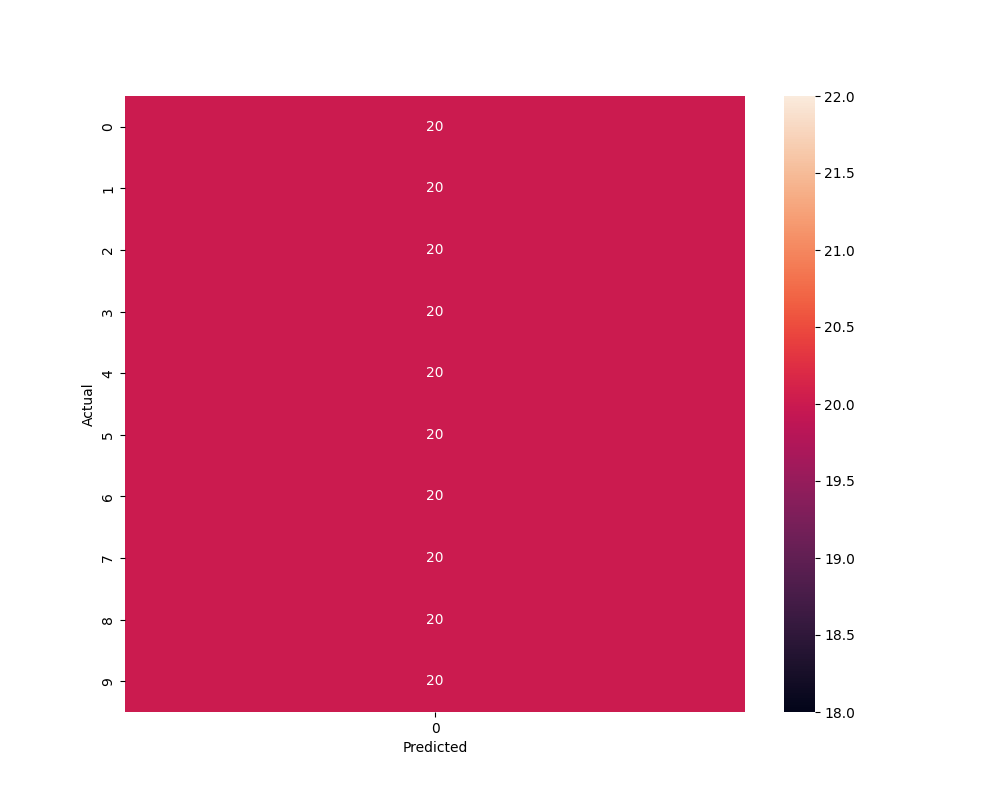

In [ ]:
if use_best_final_w:
    with open(file_path_weights, 'rb') as f:
        w_final = np.load(f)
else: 
    w_final = snn.synapses_e.w

snn = SNN(nn, ni, v_initial, w_final, 0)

pred_train = predict(snn, train_rates, classes, plot = False)
show_confusion_matrix(pred_train, train_labels)
# show_wrong_pics(pred, train_labels, train_images)

train_labels_str = [str(label) for label in train_labels]
precision, recall, F1_score = analyse(pred_train, train_labels_str)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 

Testing accuracy

Sample done: 0 / 200
Sample done: 10 / 200
Sample done: 20 / 200
Sample done: 30 / 200
Sample done: 40 / 200
Sample done: 50 / 200
Sample done: 60 / 200
Sample done: 70 / 200
Sample done: 80 / 200
Sample done: 90 / 200
Sample done: 100 / 200
Sample done: 110 / 200
Sample done: 120 / 200
Sample done: 130 / 200
Sample done: 140 / 200
Sample done: 150 / 200
Sample done: 160 / 200
Sample done: 170 / 200
Sample done: 180 / 200
Sample done: 190 / 200
Precision:  0.1
Recall:  0.1
F1_score:  0.10000000000000002


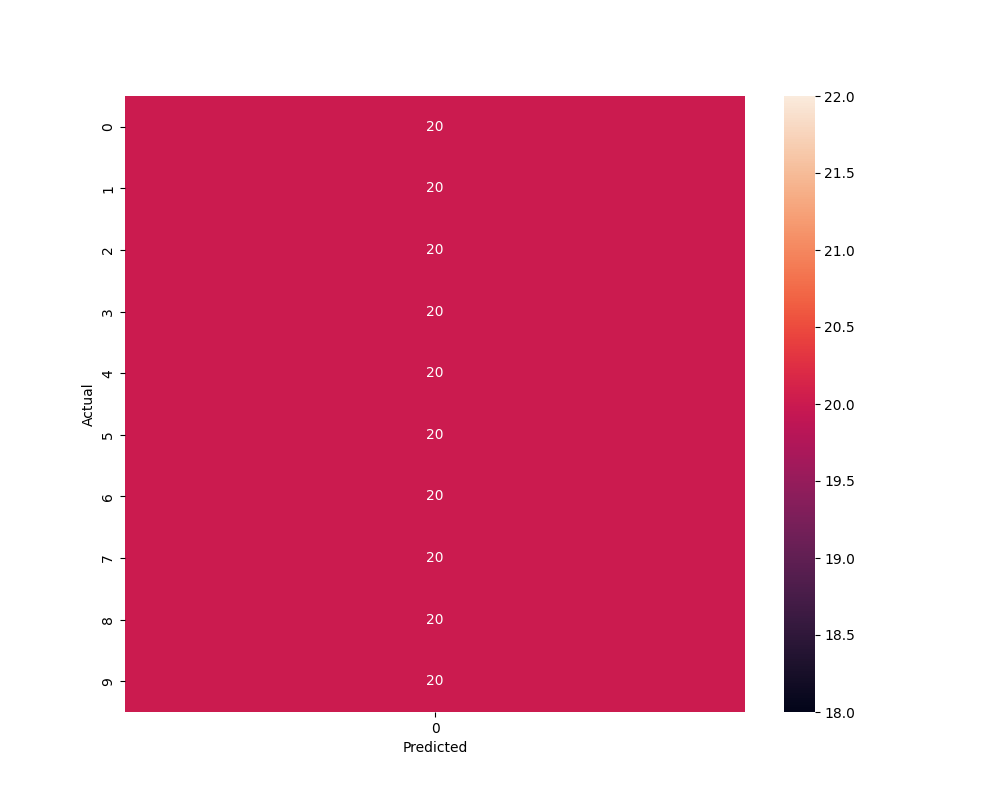

In [ ]:
if use_best_final_w:
    with open(file_path_weights, 'rb') as f:
        w_final = np.load(f)
else: 
    w_final = snn.synapses_e.w

pred_test = predict(snn, test_rates, classes, plot = False)
show_confusion_matrix(pred_test, test_labels)
# show_wrong_pics(pred, test_labels, test_images)

test_labels_str = [str(label) for label in test_labels]
precision, recall, F1_score = analyse(pred_test, test_labels_str)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", F1_score) 